# Solver

## Config file

In [2]:
from pathlib import Path
import os

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

HERE = Path(os.getcwd()) # Path(__file__) won't work in Jupyter
HERE

PosixPath('/home/hangman/Documents/solver')

In [ ]:
with open(HERE / 'config' / 'settings.yaml.bak') as f:
    config = yaml.safe_load(f)
config

{'time_end': 3,
 'time_step': 0.05,
 'f_0': 2,
 'mass': 1.0,
 'viscosity': 1.0,
 'ft_fname': 'f_t.csv',
 'area_fname': 'area.csv'}

In [32]:
new_config = {
    'time_end'  : 15,
    'time_step' : 0.5,
    'f_0'       : 4,
    'mass'      : 2,
    'viscosity' : 3,
    'ft_fname'  : 'f_t.csv',
    'area_fname': 'area.csv',
}

In [33]:
with open(HERE / 'config' / 'settings.yaml', 'w') as f:
    yaml.dump(new_config, f)

## Rust

`cargo run` will produce:

- `result/`
  - `config["area_fname"].csv`
  - `config["ft_fname"].csv`

In [34]:
!cargo run

    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.01s
     Running `target/debug/solver`
Solver { time_end: 15.0, time_step: 0.5, f_0: 4.0, mass: 2.0, viscosity: 3.0, gravity: 9.8 }

=== Final Values f(15) ===
Analytical solution: 6.533333
Euler method:        6.533333
Trapezoidal method:  6.533333

=== Integrals ∫f(t)dt from 0 to 15 ===
Analytical integral:           96.232697
Euler ODE + Trap integration:  96.944481
Trap ODE + Trap integration:   95.931091



## Plot

In [35]:
def plot_data(df) -> plt:
    plt.plot(df["timestamp"], df["euler"], label="euler", color="blue")
    plt.plot(df["timestamp"], df["trapezoid"], label="trapezoid", color="orange")
    return plt

### $f(t)$ (1st integral)

In [36]:
ft_df = pd.read_csv(
    HERE / "result" / "f_t.csv",
)
ft_df

,timestamp,euler,trapezoid
0,0.0,4.000000,4.000000
1,0.5,5.900000,5.187500
2,1.0,6.375000,5.818359
3,1.5,6.493750,6.153503
4,2.0,6.523438,6.331549
5,2.5,6.530860,6.426135
6,3.0,6.532715,6.476384
7,3.5,6.533179,6.503079
8,4.0,6.533295,6.517261
9,4.5,6.533324,6.524795


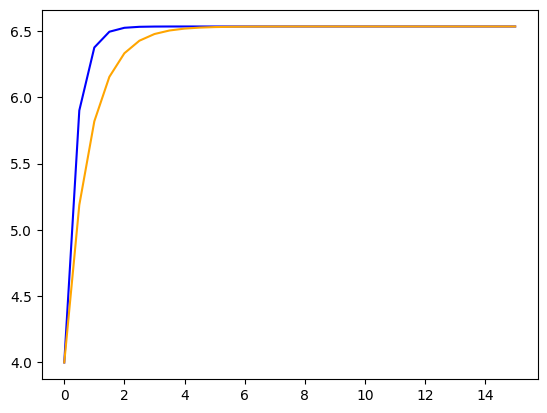

In [37]:
plot_data(ft_df).show()

### area (2nd integral)

In [38]:
area_df = pd.read_csv(
    HERE / "result" / "area.csv",
)
area_df

,timestamp,euler,trapezoid
0,0.0,0.000000,0.000000
1,0.5,2.475000,2.296875
2,1.0,5.543750,5.048340
3,1.5,8.760937,8.041306
4,2.0,12.015234,11.162569
5,2.5,15.278809,14.351990
6,3.0,18.544703,17.577620
7,3.5,21.811176,20.822485
8,4.0,25.077795,24.077570
9,4.5,28.344450,27.338083


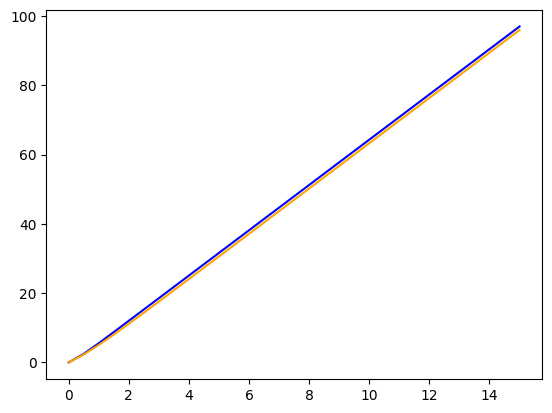

In [39]:
plot_data(area_df).show()